**Class 4: Deep Q Networks.**

1. <a href="#sec1">Environments</a>
    1. <a href="#sec1.1">Cartpole</a>
    2. <a href="#sec1.2">Cartpole swing-up</a>
    3. <a href="#sec1.3">Pong</a>
2. <a href="#sec2">Value Iteration as a sequence of Supervized Learning problems</a>
3. <a href="#sec3">Experience Replay</a>
4. <a href="#sec4">A deep Q-network</a>
5. <a href="#sec5">Making DQN more efficient</a>
    1. <a href="#sec5.1">Changing the optimizer
    2. <a href="#sec5.2">Several gradient steps
    3. <a href="#sec5.3">Target network</a>
    4. <a href="#sec5.4">Error clipping</a>
6. <a href="#sec6">Metrics</a>
7. <a href="#sec7">DQN on image-based tasks</a>
8. <a href="#sec8">Going further</a>

Let's start with this quote:

> The idea that we learn by interacting with our environment is probably the first to occur to us when we think about the nature of learning. When an infant plays, waves its arms, or looks about, it has no explicit teacher, but it does have a direct sensorimotor connection to its environment. Exercising this connection produces a wealth of information about cause and effect, about the consequences of actions, and about what to do in order to achieve goals. Throughout our lives, such interactions are undoubtedly a major source of knowledge about our environment and ourselves. Whether we are learning to drive a car or to hold a conversation, we are acutely aware of how our environment responds to what we do, and we seek to influence what happens through our behavior. Learning from interaction is a foundational idea underlying nearly all theories of learning and intelligence. (Richard S. Sutton)

# <a id="sec1"></a> Environments

In this session, we will work with three different environments:
- CartPole
- A modified version of CartPole
- Pong

In [1]:
import gym
from gym import logger
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt
logger.set_level(gym.logger.DISABLED)

## <a id=sec1.1></a>CartPole

In [2]:
cartpole = gym.make('CartPole-v1')

From the [OpenAI Gym website](https://gym.openai.com/envs/CartPole-v0/)

> A pole is attached by an un-actuated joint to a cart, which moves along a frictionless track. The system is controlled by applying a force of +1 or -1 to the cart. The pendulum starts upright, and the goal is to prevent it from falling over. A reward of +1 is provided for every timestep that the pole remains upright. The episode ends when the pole is more than 15 degrees from vertical, or the cart moves more than 2.4 units from the center.

Beware that, as most Gym environments, CartPole has a maximum number of steps before necessarily returning `done=True`.

In [3]:
cartpole._max_episode_steps

500

The cartpole is represented by a state $s = (x, \dot{x}, \theta, \dot{\theta})$ with :
  - $x$ the position of the cartpole along the x-axis
  - $\theta$ the angle of the pole

In [4]:
print(cartpole.action_space)
print(cartpole.observation_space)
print(cartpole.env.metadata)

Discrete(2)
Box(4,)
{'render.modes': ['human', 'rgb_array'], 'video.frames_per_second': 50}


In [5]:
x = cartpole.reset()
cartpole.render()
for i in range(1000):
    _, _, d, _ = cartpole.step(np.random.randint(2))
    cartpole.render()
    if d:
        print(i)
        break

cartpole.close()

30


## <a id=sec1.2></a>CartPole Swing-up

The idea here is to keep the same environment, but instead of learning how to stabilize it around the unstable equilibrium point, we'd like to learn to swing it up. Here are the changes:
- `reset` now puts the pole pointing down. The initial state is $(0,0,\pi,0)$ plus a vector of four uniformly random values in [-0.05,0.05].
- `step` now returns `done=True` when the cart leaves the $x\in [-2.4,2.4]$ interval or when the pole swings faster than $4\pi$ radians per second.
- the reward is still +1 for keeping the pole within 12 degrees of the vertical, it is 0 for all other time steps and -10 for swinging too fast or exiting the screen.

In [6]:
class CartPoleSwingUp(gym.Wrapper):
    def __init__(self, env, **kwargs):
        super(CartPoleSwingUp, self).__init__(env, **kwargs)
        self.theta_dot_threshold = 4*np.pi

    def reset(self):
        self.env.env.state = [0, 0, np.pi, 0] + super().reset()
        #self.state = [0,0,np.pi,0] + self.np_random.uniform(low=-0.05, high=0.05, size=(4,))
        self.env.env.steps_beyond_done = None
        return np.array(self.env.env.state)

    def step(self, action):
        state, reward, done, _ = super().step(action)
        #self.state = state
        x, x_dot, theta, theta_dot = state
        theta = (theta+np.pi)%(2*np.pi)-np.pi
        self.env.env.state = [x, x_dot, theta, theta_dot]
        
        done = x < -self.x_threshold \
               or x > self.x_threshold \
               or theta_dot < -self.theta_dot_threshold \
               or theta_dot > self.theta_dot_threshold
        
        if done:
            # game over
            reward = -10.
            if self.steps_beyond_done is None:
                self.steps_beyond_done = 0
            else:
                logger.warn("You are calling 'step()' even though this environment has already returned done = True. You should always call 'reset()' once you receive 'done = True' -- any further steps are undefined behavior.")
                self.steps_beyond_done += 1
        else:
            if -self.theta_threshold_radians < theta and theta < self.theta_threshold_radians:
                # pole upright
                reward = 1.
            else:
                # pole swinging
                reward = 0.

        return np.array([x, x_dot, theta, theta_dot]), reward, done, {}

In [7]:
swingup = CartPoleSwingUp(gym.make('CartPole-v1'))

In [8]:
x = swingup.reset()
swingup.render()

for i in range(1000):
    _, _, d, _ = swingup.step(np.random.randint(2))
    swingup.render()
    if d:
        print(i)
        break

swingup.close()

129


## <a id=sec1.3></a>Pong

Let's build an agent that learns to play Pong, one of the [Atari games](https://github.com/openai/gym/blob/master/gym/envs/atari/atari_env.py) in Gym (originally in the [Arcade Learning Environment](https://github.com/mgbellemare/Arcade-Learning-Environment)). You might want to try different games later on (like the popular Breakout game for instance).

In [9]:
pong = gym.make('Pong-v4')

Here is the environment's description.
> Maximize your score in the Atari 2600 game Pong. In this environment, the observation is an RGB image of the screen, which is an array of shape (210, 160, 3). Each action is repeatedly performed for a duration of k frames, where k is uniformly sampled from $\{2, 3, 4\}$.

In [10]:
print(pong.observation_space)
print(pong.observation_space.shape)
print(np.min(pong.observation_space.low))
print(np.max(pong.observation_space.high))
print(pong.action_space)
#help(env.observation_space)

Box(210, 160, 3)
(210, 160, 3)
0
255
Discrete(6)


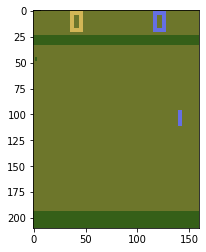

In [11]:
x = pong.reset()
plt.imshow(x)
plt.show()

<div class="alert alert-warning">

**Exercice:** What is the number of possible states? Why is this not an MDP? What would one need to turn this back into an MDP?
</div>

<div class="alert alert-danger">
    <a href="#Pong-theory" data-toggle="collapse"><b>Answers:</b></a><br>
<div id="Pong-theory" class="collapse">

One frame is a $210\times 160$ RGB image with a 256 color palette, so the set of all possible frames has size $256^{210 \times 160 \times 3} \sim 10^{242579}$. That's a little too many for an efficient enumeration. Of course, most of the possible images will never occur in a Breakout game and the true state space is actually a much smaller subset of the full set of possible images. Nevertheless, unless we provide a large engineering effort in describing the state space with few variables (which would be contradictory of our goal of a "human-level" AI) we will need to automatically discover some structure in the state sampled data.

This is not an MDP because the transition dynamics do not respect Markov's property. The probability of transitioning from $s_t$ to $s_{t+1}$ is *not* independent of previous states. The problem here is that a single frame of the game does not reflect the velocity of the ball.

To recover Markov's property one could simply stack a few frames together in the state space.
</div>
</div>

There are 18 buttons on the Atari controller. However not all games use all buttons. Our interface to Pong specifies 6 possible actions:
- 0 NOOP (no operation)
- 1 FIRE (press fire button, doesn't do anything in Pong)
- 2 RIGHT (actually moves the paddle up in Pong)
- 3 LEFT (actually moves the paddle left in Pong)
- 4 UP (moves the paddle upwards)
- 5 DOWN (moves the paddle downwards)

The available actions in Pong go up to the 6th action for naming consistency (UP and DOWN), but the four first actions are not really useful.

Also, for an unknown reason, the game does not start until the 20th frame (but always starts automatically, pressing FIRE does not change anything).

The frame rate is 60Hz.

To avoid confusion between the 6 actions allowed by Gym, let's build a wrapper around our environment, with only 2 possible actions ("0" for UP and "1" for DOWN) and a downscaled observation space. Unless you're curious and want to dig in the code, you can simply run the following cells and just use the resulting environment.

In [12]:
from gym.wrappers import AtariPreprocessing
import cv2

class PongWrapper(AtariPreprocessing):
    def __init__(self, env, **kwargs):
        super(PongWrapper, self).__init__(env, **kwargs)

    def step(self, action):
        return super(PongWrapper, self).step(4 + action)

    def _get_obs(self):
        if self.frame_skip > 1:  # more efficient in-place pooling
            np.maximum(self.obs_buffer[0], self.obs_buffer[1], out=self.obs_buffer[0])
        obs = cv2.resize(self.obs_buffer[0], (84, 110), interpolation=cv2.INTER_AREA)[17:101,:]

        if self.scale_obs:
            obs = np.asarray(obs, dtype=np.float32) / 255.0
        else:
            obs = np.asarray(obs, dtype=np.uint8)
        return obs

In [13]:
pong = PongWrapper(gym.make('PongNoFrameskip-v4'),
                   noop_max=0,
                   frame_skip=4,
                   terminal_on_life_loss=True,
                   grayscale_obs=True,
                   scale_obs=True)

shape: (84, 84), min = 0.34117648, max = 0.9137255, dtype = float32


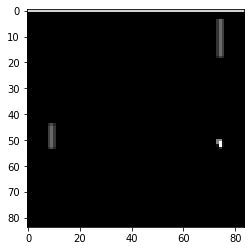

In [14]:
# Trying a random agent in Pong
import time

pong.reset()
pong.render()
for i in range(60):
    a = np.random.randint(2)
    x, r, _, _ = pong.step(a)
    pong.render()
    #print('\r', "reward", r, end="")
    time.sleep(0.1)
    
pong.close()
print("shape: ", x.shape, ", min = ", x.min(), ", max = ", x.max(), ", dtype = ", x.dtype, sep='')
plt.imshow(x, cmap='gray');

# <a id=sec2></a>Value Iteration as a sequence of Supervized Learning problems

<div class="alert alert-warning">

**Exercice:** start from the Value Iteration update and write $Q_{n+1}$ as a regression problem with parameters $\theta_{n+1}$. Specify the loss function minimized for this regression problem.
</div>

<div class="alert alert-danger">
    <a href="#ValueIteration" data-toggle="collapse"><b>Answers:</b></a><br>
<div id="ValueIteration" class="collapse">

Let's start over from the beginning. We want to find:
$$\pi^*(s) = \arg\max_{\pi} \mathbb{E}_{\left(r_t\right)_{t\in \mathbb{N}}} \left[ \sum_{t=0}^\infty \gamma^t r_t \ \Big| \ s, \pi \right], \ \forall s\in S.$$

We have seen this was equivalent to finding the optimal value function $Q^*$:
$$Q^*(s,a) = \max_{\pi} \mathbb{E}_{\left(r_t\right)_{t\in \mathbb{N}}} \left[ \sum_{t=0}^\infty \gamma^t r_t \ \Big| \  s,a, \pi \right], \ \forall (s,a) \in S\times A.$$

And we have established that $Q^*$ was the only solution to Bellman's optimality equation:
$$Q(s,a) = \mathbb{E}_{s' \sim p(\cdot|s,a)} \left[r(s,a,s') + \gamma \max_{a'} Q(s',a')\right].$$

By writing $T^*$ Bellman's optimality operator, we have, by definition:
$$(T^*Q)(s,a) = \mathbb{E}_{s' \sim p(\cdot|s,a)} \left[r(s,a,s') + \gamma \max_{a'} Q(s',a')\right].$$

And thus, $Q^*$ is the only solution to $Q=T^*Q$.

It appears $T^*$ is a contraction mapping on the $\mathcal{F}(S\times A,\mathbb{R})$ space. Value Iteration exploits this property to build the sequence $Q_{n+1} = T^*Q_n$ which converges to $Q^*$.

Let's now suppose that $Q_n$ is a function approximator, whose parameters are $\theta_n$. We shall write $Q_n(s,a) = Q(s,a;\theta_n)$. Then building $\theta_{n+1}$ knowing $\theta_n$ is the regression problem that minimizes the loss:
\begin{gather}
L_n(\theta) = \left\| y_n(s,a) - Q(s,a;\theta) \right\|,\\
\textrm{with } y_n(s,a) = \mathbb{E}_{s' \sim p(\cdot|s,a)} \left[r(s,a,s') + \gamma \max_{a'} Q(s',a',\theta_{n})\right].
\end{gather}

If this loss can be optimized and goes to zero, then we have found the true $Q_{n+1}$. If not, then we have found an approximation of it in the norm used to define $L_n$.

</div>
</div>

<div class="alert alert-warning">

**Exercice:** use the L2 norm in the loss of the regression problem above, then write the gradient of the loss with respect to the regressor's parameters. Use this to introduce a stochastic gradient descent method to find $\theta_{n+1}$.
</div>

<div class="alert alert-danger">
    <a href="#VILoss" data-toggle="collapse"><b>Answers:</b></a><br>
<div id="VILoss" class="collapse">

Our loss becomes:
\begin{gather}
L_n(\theta) = \frac{1}{2} \mathbb{E}_{(s,a) \sim \rho(\cdot)}\left[ \big( y_n(s,a) - Q(s,a;\theta) \big)^2 \right],\\
\textrm{with } y_n(s,a) = \mathbb{E}_{s' \sim p(\cdot|s,a)} \left[r(s,a,s') + \gamma \max_{a'} Q(s',a',\theta_{n})\right].
\end{gather}

In the expression above, $\rho$ is a distribution over the state-action space. Often, it is considered to be the behavior distribution, that is the distribution of samples under the current behavior policy, like $\epsilon$-greedy. Note that this choice is debatable.

So the gradient of this loss is:
\begin{gather}
\nabla_\theta L_n(\theta) = \mathbb{E}_{(s,a) \sim \rho(\cdot)}\left[ \big( y_n(s,a) - Q(s,a;\theta) \big) \nabla_\theta Q(s,a;\theta) \right]\\
\textrm{with } y_n(s,a) = \mathbb{E}_{s' \sim p(\cdot|s,a)} \left[r(s,a,s') + \gamma \max_{a'} Q(s',a',\theta_{n})\right].
\end{gather}

And when we wrap all this together:
$$\nabla_\theta L_n(\theta) = \mathbb{E}_{(s,a) \sim \rho(\cdot)}\left[ \left( \mathbb{E}_{s' \sim p(\cdot|s,a)} \left[r(s,a,s') + \gamma \max_{a'} Q(s',a',\theta_{n})\right] - Q(s,a;\theta) \right) \nabla_\theta Q(s,a;\theta) \right]$$

$$\nabla_\theta L_n(\theta) = \mathbb{E}_{\substack{(s,a) \sim \rho(\cdot)\\ s' \sim p(\cdot|s,a)}}\left[ \left( r(s,a,s') + \gamma \max_{a'} Q(s',a',\theta_{n}) - Q(s,a;\theta) \right) \nabla_\theta Q(s,a;\theta) \right]$$

Rather than computing the full expectations in the above gradient, it is often computationally expedient to optimise the loss function by stochastic gradient descent. Then the stochastic estimate of the gradient is given by:
$$\nabla_\theta L_n(\theta) \approx d_n(\theta) = \sum_{i=1}^B \left[ \left( r_i + \gamma \max_{a'} Q(s_i',a',\theta_{n}) - Q(s_i,a_i;\theta) \right) \nabla_\theta Q(s_i,a_i;\theta) \right],$$
where $\left\{ \left(s_i,a_i,r_i,s'_i\right) \right\}_{i\in {1,B}}$ is a mini-batch of samples drawn independently, with $(s,a) \sim \rho(\cdot)$ and $s' \sim p(\cdot | s,a)$.

The stochastic gradient descent procedure builds a sequence of parameter values $\theta_i$ such that:
$$\theta_{i+1} \leftarrow \theta_{i} - \alpha d_n(\theta_{i})$$

By repeating such gradient steps, one progressively minimizes $L_n(\theta)$ and finds $\theta_{n+1}$.

</div>
</div>

**Important remark:**

In the update above, if the mini-batch contains a single element, the 1-sample update is precisely that of Q-learning! Then, in Q-learning, the new loss $L_{n+1}$ is defined and the process is repeated. Consequently, there is a new loss function at each time step.

<div class="alert alert-warning">

**Exercice:** can you spot the (subtle but essential) difference with Q-learning?
</div>

<div class="alert alert-danger">
    <a href="#DifferenceQL" data-toggle="collapse"><b>Answers:</b></a><br>
<div id="DifferenceQL" class="collapse">

Recall Q-learning. The update was indeed the same, except that at any time step the mini-batch's single element was not sampled independently from the previous minibatch! Indeed, $s'$ from the previous time step becomes $s$ for the current time step. So the successive mini-batches' elements are not drawn iid.

That's a key difference that questions the foundation of Q-learning in itself.
</div>
</div>

# <a id=sec3></a>Experience Replay

To recover the independence assumption between samples, we can introduce the mechanism of [*Experience Replay*](http://www.incompleteideas.net/lin-92.pdf) by storing past samples into a *Replay Memory*. When samples a required for a mini-batch gradient update, the samples are collected uniformly from the replay memory, thus mimicking an (almost) independent draw according to $\rho(\cdot)$.

<div class="alert alert-warning">
    
**Exercice:** design a class for the replay memory of the cart-pole example(s). Limit the size of this memory (via a FIFO mechanism) to $10^6$ samples (adapt this number to your computer's RAM). Test it by running a random policy for $2\cdot 10^6$ time steps.
</div>

In [15]:
# YOUR REPLAY BUFFER CODE

In [16]:
# Note that a simple double-ended queue from collections.deque might do the job for a small replay buffer.
# But as we will discuss later, it's better to think about the data structures we use.

import random

class ReplayBuffer:
    def __init__(self, capacity):
        self.capacity = capacity # capacity of the buffer
        self.data = []
        self.index = 0 # index of the next cell to be filled

    def append(self, s, a, r, s_, d):
        if len(self.data) < self.capacity:
            self.data.append(None)
        self.data[self.index] = (s, a, r, s_, d)
        self.index = (self.index + 1) % self.capacity

    def sample(self, batch_size):
        return random.sample(self.data, batch_size)

    def __len__(self):
        return len(self.data)

In [ ]:
# Testing insertion in the ReplayBuffer class
from tqdm import trange
replay_buffer_size = int(1e6)
nb_samples = int(2e6)

memory = ReplayBuffer(replay_buffer_size)
state = cartpole.reset()
for _ in trange(nb_samples):
    action = cartpole.action_space.sample()
    next_state, reward, done, _ = cartpole.step(action)
    memory.append(state, action, reward, next_state, done)
    if done:
        state = cartpole.reset()
    else:
        state = next_state

print(len(memory))

In [ ]:
nb_batches = int(1e4)
batch_size = 50

# Testing sampling in the ReplayBuffer class
import random

for _ in trange(nb_batches):
    batch = memory.sample(batch_size)

In [ ]:
print(memory.sample(2))

<div class="alert alert-warning">
    
**Know your data structures!**

Taking the time to think about what makes a good replay buffer may save you hours of puzzled head-banging. It is important to know what you expect from your replay buffer to choose the right data structure.

Common mistake: we need a fixed sized memory, that works like a FIFO structure, so let's pick a deque. That sounds fair, deques (in Python) have a fixed maximum size and constant time insertion at the beginning and the end. BUT they also have $O(n)$ access time which means that for large replay buffers, sampling a minibatch may take forever.

Here, what we really need is a fixed-size FIFO, with $O(1)$ insertion at the end and $O(1)$ access.

This should motivate the choices made in the replay buffer class above.
</div>

# <a id=sec4></a>A deep Q-network

The term Deep Q-Network was coined by the (now historical) paper **[Playing Atari with Deep Reinforcement Learning](https://arxiv.org/abs/1312.5602)** by Mnih et al. (2013) that put forward the main ideas we develop here. All those were later popularized by DeepMind's paper in Nature **[Human-level control through deep reinforcement learning](https://deepmind.com/research/publications/human-level-control-through-deep-reinforcement-learning)** by Mnih et al. (2015).

Let's design a (deep) neural network that will serve as a function approximator for $Q(s,a;\theta)$. 

<img src="../images/dqlas.png" height="15%" width="15%"></img>

Note that since we're going to have to compute $\max_a Q(s,a)$ it is preferable to avoid running as many passes through the network as there are actions. Therefore, instead of the network structure above, we will prefer to use the one below.

<img src="../images/dqls.png" height="30%" width="30%"></img>

<div class="alert alert-warning">
    
**Exercice:** declare a neural network for our Q function. For the CartPole task, you can use a simple network with 2 hidden layers and 16 neurons on each layer. For the SwingUp task, go up to 50 neurons per layer. For Pong... well wait a minute, we'll get to it later.
</div>

In [ ]:
# YOUR NEURAL NETWORK CODE

In [17]:
import torch
import torch.nn as nn

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

state_dim = cartpole.observation_space.shape[0]
n_action = cartpole.action_space.n 
nb_neurons=24

DQN = torch.nn.Sequential(nn.Linear(state_dim, nb_neurons),
                          nn.ReLU(),
                          nn.Linear(nb_neurons, nb_neurons),
                          nn.ReLU(), 
                          nn.Linear(nb_neurons, n_action)).to(device)

We're almost there. Now you can implement the algorithm that:
- takes $\epsilon$-greedy actions with respect to $Q$
- stores samples in the replay buffer
- at each interaction step with the environment, draws a mini-batch, computes the target values for each $(s,a)$ and takes a gradient step.
- repeats

<div class="alert alert-warning">
    
**Exercice:** write this algorithm's pseudo-code, then proceed with your implementation, using the network and replay buffer you defined in the previous cells.
</div>

You can take inspiration from the algorithm on page 5 of [Playing Atari with Deep Reinforcement Learning](https://arxiv.org/abs/1312.5602).

<div class="alert alert-danger">
    <a href="#DQNpseudocode" data-toggle="collapse"><b>Answer:</b></a><br>
<div id="DQNpseudocode" class="collapse">

         state = init()
         loop:
            action = greedy_action(DQN) or random_action()
            new_state, reward = step(state, action)
            replay_memory.add(state, action, reward, new_state)
            minibatch = replay_memory.sample(minibatch_size)
            X_train = Y_train = []
            for (s,a,r,s') in minibatch:
                Q  = DQN.predict(s)
                Q' = DQN.predict(s')
                if non-terminal(s'): 
                    update = r + gamma * max(Q')    
                else:  
                    update = r
                Q[a] = update
                X_train.add(s)
                Y_train.add(Q)
            DQN.train_one_step(X_train,Y_train)
            state = new_state
</div>
</div>

A common optimizer (instead of plain SGD) is RMSprop. But don't run this code just yet!

In [18]:
# YOUR DEEP Q LEARNING CODE

In [19]:
# It will actually be useful to have separate torch.Tensor for the each element type in the sampled minibatch.
# That is one Tensor for a minibatch of states, another for actions, etc.
# Let's redefine the sample function of our replay buffer class to that end.
import random

class ReplayBuffer:
    def __init__(self, capacity):
        self.capacity = capacity # capacity of the buffer
        self.data = []
        self.index = 0 # index of the next cell to be filled

    def append(self, s, a, r, s_, d):
        if len(self.data) < self.capacity:
            self.data.append(None)
        self.data[self.index] = (s, a, r, s_, d)
        self.index = (self.index + 1) % self.capacity

    def sample(self, batch_size):
        batch = random.sample(self.data, batch_size)
        return list(map(lambda x:torch.Tensor(x).to(device), list(zip(*batch))))

    def __len__(self):
        return len(self.data)

In [20]:
# Let's define a utility function that gives us the greedy action from a DQN
import torch

def greedy_action(network, state):
    #device = "cuda" if next(network.parameters()).is_cuda else "cpu"
    with torch.no_grad():
        Q = network(torch.Tensor(state).unsqueeze(0).to(device))
        return torch.argmax(Q).item()

In [21]:
# The Deep Q-learning algorithm's class

import numpy as np
import torch
import torch.nn as nn

class DQN_agent:
    def __init__(self, config, model):
        self.gamma = config['gamma']
        self.batch_size = config['batch_size']
        self.nb_actions = config['nb_actions']
        self.memory = ReplayBuffer(config['buffer_size'])
        self.epsilon_max = config['epsilon_max']
        self.epsilon_min = config['epsilon_min']
        self.epsilon_stop = config['epsilon_decay_period']
        self.epsilon_delay = config['epsilon_delay_decay']
        self.epsilon_step = (self.epsilon_max-self.epsilon_min)/self.epsilon_stop
        self.total_steps = 0
        self.model = model 
        self.criterion = torch.nn.MSELoss()
        self.optimizer = torch.optim.RMSprop(self.model.parameters(), lr=config['learning_rate'])
    
    def gradient_step(self):
        if len(self.memory) > self.batch_size:
            X, A, R, Y, D = self.memory.sample(self.batch_size)
            QYmax = self.model(Y).max(1)[0].detach()
            update = torch.addcmul(R, self.gamma, 1-D, QYmax)
            QXA = self.model(X).gather(1, A.to(torch.long).unsqueeze(1))
            loss = self.criterion(QXA, update.unsqueeze(1))
            self.optimizer.zero_grad()
            loss.backward()
            self.optimizer.step() 
    
    def train(self, env, max_episode):
        episode_return = []
        episode = 0
        episode_cum_reward = 0
        state = env.reset()
        epsilon = self.epsilon_max
        step = 0

        while episode < max_episode:
            # update epsilon
            if step > self.epsilon_delay:
                epsilon = max(self.epsilon_min, epsilon-self.epsilon_step)

            # select epsilon-greedy action
            if np.random.rand() < epsilon:
                action = np.random.randint(self.nb_actions)
            else:
                action = greedy_action(self.model, state)

            # step
            next_state, reward, done, _ = env.step(action)
            self.memory.append(state, action, reward, next_state, done)
            episode_cum_reward += reward

            # train
            self.gradient_step()

            # next transition
            step += 1
            if done:
                episode += 1
                print("Episode ", '{:3d}'.format(episode), 
                      ", epsilon ", '{:6.2f}'.format(epsilon), 
                      ", batch size ", '{:5d}'.format(len(self.memory)), 
                      ", episode return ", '{:4.1f}'.format(episode_cum_reward),
                      sep='')
                state = env.reset()
                episode_return.append(episode_cum_reward)
                episode_cum_reward = 0
            else:
                state = next_state

        return episode_return

Episode   1, epsilon   0.98, batch size    38, episode return 38.0
Episode   2, epsilon   0.96, batch size    57, episode return 19.0
Episode   3, epsilon   0.95, batch size    72, episode return 15.0
Episode   4, epsilon   0.93, batch size    91, episode return 19.0
Episode   5, epsilon   0.92, batch size   102, episode return 11.0
Episode   6, epsilon   0.90, batch size   118, episode return 16.0
Episode   7, epsilon   0.89, batch size   132, episode return 14.0
Episode   8, epsilon   0.88, batch size   146, episode return 14.0
Episode   9, epsilon   0.86, batch size   167, episode return 21.0
Episode  10, epsilon   0.81, batch size   212, episode return 45.0
Episode  11, epsilon   0.79, batch size   230, episode return 18.0
Episode  12, epsilon   0.77, batch size   250, episode return 20.0
Episode  13, epsilon   0.76, batch size   265, episode return 15.0
Episode  14, epsilon   0.75, batch size   277, episode return 12.0
Episode  15, epsilon   0.73, batch size   295, episode return 

Episode 123, epsilon   0.01, batch size 21271, episode return 359.0
Episode 124, epsilon   0.01, batch size 21569, episode return 298.0
Episode 125, epsilon   0.01, batch size 21914, episode return 345.0
Episode 126, epsilon   0.01, batch size 22207, episode return 293.0
Episode 127, epsilon   0.01, batch size 22513, episode return 306.0
Episode 128, epsilon   0.01, batch size 22830, episode return 317.0
Episode 129, epsilon   0.01, batch size 23173, episode return 343.0
Episode 130, epsilon   0.01, batch size 23597, episode return 424.0
Episode 131, epsilon   0.01, batch size 23901, episode return 304.0
Episode 132, epsilon   0.01, batch size 24288, episode return 387.0
Episode 133, epsilon   0.01, batch size 24553, episode return 265.0
Episode 134, epsilon   0.01, batch size 24816, episode return 263.0
Episode 135, epsilon   0.01, batch size 25186, episode return 370.0
Episode 136, epsilon   0.01, batch size 25501, episode return 315.0
Episode 137, epsilon   0.01, batch size 25943, e

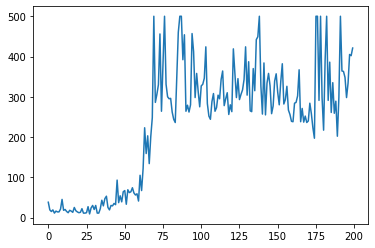

In [22]:
config = {'observation_space': cartpole.observation_space.shape[0],
          'nb_actions': cartpole.action_space.n,
          'learning_rate': 0.001,
          'gamma': 0.95,
          'buffer_size': 1000000,
          'epsilon_min': 0.01,
          'epsilon_max': 1.,
          'epsilon_decay_period': 1000,
          'epsilon_delay_decay': 20,
          'batch_size': 20}

agent = DQN_agent(config, DQN)
scores = agent.train(cartpole, 200)
plt.plot(scores);

In [23]:
x = cartpole.reset()
cartpole.render()
for i in range(1000):
    a = greedy_action(DQN, x)
    y, _, d, _ = cartpole.step(a)
    cartpole.render()
    x=y
    if d:
        print(i)
        break

cartpole.close()

499


# <a id=sec5></a>Making DQN more efficient


## <a id=sec5.1></a>Changing the optimizer

The question of which optimizer to choose is quite open in RL. Most common choices are RMSprop or Adam (with, sometimes, carefully chosen hyperparameters). For the example of cart-pole, it seems Adam with default parameters works better, but that's not a general rule.

## <a id=sec5.2></a>Several gradient steps

Recall that within an iteration of Value Iteration, one aims at minimizing the $L_n(\theta)$ (before moving on to the next iteration). Why take a single gradient step on this loss when a new sample is collected? Taking several gradient steps can greatly accelerate the convergence in terms of number of collected samples. That's what is commonly called *sample efficiency*.

## <a id=sec5.3></a>Target network
It appears the code above will (probably) slowly converge to $Q^*$ but this convergence might be unstable and noisy. This can be greatly improved by taking several gradient steps on a given loss function $L_n$ instead of changing the loss function after each sample. This idea is similar to the one above.

In practice, this is achieved by the introduction of a *target network* whose parameters are noted $\theta^-$. This idea was introduced in the [Human-level control through deep reinforcement learning](https://deepmind.com/research/publications/human-level-control-through-deep-reinforcement-learning) paper. At any time step, the loss becomes:
$$L(\theta) = \mathbb{E}_{s,a,r,s'} \left[ \left( r + \gamma \max_{a'} Q(s',a',\theta^-) - Q(s,a;\theta) \right) ^2 \right],$$
and the target network parameters $\theta^-$ are only updated with the Q-network parameters $\theta_n$ every $C$ steps and are held fixed between individual updates.

This process of accumulating several gradient steps into $\theta_n$ before updating $\theta^-$ draws our algorithm closer to a Value Iteration scheme (or a Fitted Q-Iteration scheme for that matter).

Note that more recent approaches smooth out this accumulation process by defining soft updates of the form:
$$\theta^- \leftarrow \beta \theta^- + (1-\beta) \theta_n.$$

## <a id=sec5.4></a>Error clipping

Another common pratice to stabilize learning is to clip the value of the loss' gradient between $-1$ and $1$. This is not such an uncommon trick, it actually amounts to using an L2 loss for values of the loss between $-1$ and $1$ and an L1 loss outside of this domain. This is also know as the [Huber Loss](https://en.wikipedia.org/wiki/Huber_loss) or the [smooth L1 loss](https://pytorch.org/docs/stable/nn.html#smoothl1loss).

<div class="alert alert-warning">
    
**Exercice:** modify you code above to include a target network (with $C$ in the order of $100$), a fixed number of gradient steps per acquired sample, and the clipping of the error term. You can also use Adam for improved efficiency. Then run it to learn an efficient policy for CartPole (then for SwingUp).
</div>

In [ ]:
# YOUR IMPROVED DEEP Q LEARNING CODE

In [24]:
# Let's reset the Q function

import torch
import torch.nn as nn

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

state_dim = cartpole.observation_space.shape[0]
n_action = cartpole.action_space.n 
nb_neurons=24

DQN = torch.nn.Sequential(nn.Linear(state_dim, nb_neurons),
                          nn.ReLU(),
                          nn.Linear(nb_neurons, nb_neurons),
                          nn.ReLU(), 
                          nn.Linear(nb_neurons, n_action)).to(device)

In [25]:
import numpy as np
import torch
import torch.nn as nn
from copy import deepcopy

class DQN_agent:
    def __init__(self, config, model):
        self.gamma = config['gamma']
        self.batch_size = config['batch_size']
        self.nb_actions = config['nb_actions']
        self.memory = ReplayBuffer(config['buffer_size'])
        self.epsilon_max = config['epsilon_max']
        self.epsilon_min = config['epsilon_min']
        self.epsilon_stop = config['epsilon_decay_period']
        self.epsilon_delay = config['epsilon_delay_decay']
        self.epsilon_step = (self.epsilon_max-self.epsilon_min)/self.epsilon_stop
        self.nb_gradient_steps = config['gradient_steps'] # NEW NEW NEW
        self.total_steps = 0
        self.model = model 
        self.criterion = torch.nn.SmoothL1Loss() # NEW NEW NEW
        self.optimizer = torch.optim.Adam(self.model.parameters(), lr=config['learning_rate']) # NEW NEW NEW
        self.target_model = deepcopy(self.model).to(device) # NEW NEW NEW
        self.update_target_freq = config['update_target_freq'] # NEW NEW NEW
    
    def gradient_step(self):
        if len(self.memory) > self.batch_size:
            X, A, R, Y, D = self.memory.sample(self.batch_size)
            QYmax = self.target_model(Y).max(1)[0].detach()
            update = torch.addcmul(R, self.gamma, 1-D, QYmax)
            QXA = self.model(X).gather(1, A.to(torch.long).unsqueeze(1))
            loss = self.criterion(QXA, update.unsqueeze(1))
            self.optimizer.zero_grad()
            loss.backward()
            self.optimizer.step() 
    
    def train(self, env, max_episode):
        episode_return = []
        episode = 0
        episode_cum_reward = 0
        state = env.reset()
        epsilon = self.epsilon_max
        step = 0
        while episode < max_episode:
            # update epsilon
            if step > self.epsilon_delay:
                epsilon = max(self.epsilon_min, epsilon-self.epsilon_step)

            # select epsilon-greedy action
            if np.random.rand() < epsilon:
                action = np.random.randint(self.nb_actions)
            else:
                action = greedy_action(self.model, state)

            # step
            next_state, reward, done, _ = env.step(action)
            self.memory.append(state, action, reward, next_state, done)
            episode_cum_reward += reward

            # train
            for _ in range(self.nb_gradient_steps): # NEW NEW NEW
                self.gradient_step()

            # update target network if needed
            if step % self.update_target_freq == 0: # NEW NEW NEW
                self.target_model.load_state_dict(self.model.state_dict())   
            
            # next transition
            step += 1
            if done:
                episode += 1
                print("Episode ", '{:3d}'.format(episode), 
                      ", epsilon ", '{:6.2f}'.format(epsilon), 
                      ", batch size ", '{:5d}'.format(len(self.memory)), 
                      ", episode return ", '{:4.1f}'.format(episode_cum_reward),
                      sep='')
                state = env.reset()
                episode_return.append(episode_cum_reward)
                episode_cum_reward = 0
            else:
                state = next_state

        return episode_return

In [26]:
config = {'observation_space': cartpole.observation_space.shape[0],
          'nb_actions': cartpole.action_space.n,
          'learning_rate': 0.001,
          'gamma': 0.95,
          'buffer_size': 1000000,
          'epsilon_min': 0.01,
          'epsilon_max': 1.,
          'epsilon_decay_period': 1000,
          'epsilon_delay_decay': 20,
          'batch_size': 20,
          'gradient_steps': 10,
          'update_target_freq': 100}

agent = DQN_agent(config, DQN)
scores = agent.train(cartpole, 50)

Episode   1, epsilon   1.00, batch size    15, episode return 15.0
Episode   2, epsilon   0.99, batch size    36, episode return 21.0
Episode   3, epsilon   0.96, batch size    64, episode return 28.0
Episode   4, epsilon   0.94, batch size    78, episode return 14.0
Episode   5, epsilon   0.92, batch size   103, episode return 25.0
Episode   6, epsilon   0.91, batch size   114, episode return 11.0
Episode   7, epsilon   0.89, batch size   131, episode return 17.0
Episode   8, epsilon   0.88, batch size   143, episode return 12.0
Episode   9, epsilon   0.86, batch size   166, episode return 23.0
Episode  10, epsilon   0.85, batch size   177, episode return 11.0
Episode  11, epsilon   0.83, batch size   192, episode return 15.0
Episode  12, epsilon   0.81, batch size   215, episode return 23.0
Episode  13, epsilon   0.79, batch size   235, episode return 20.0
Episode  14, epsilon   0.75, batch size   278, episode return 43.0
Episode  15, epsilon   0.73, batch size   295, episode return 

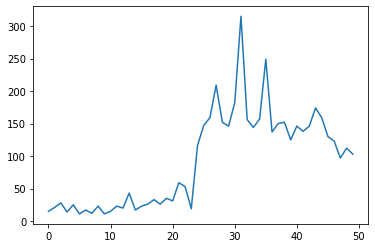

In [27]:
plt.plot(scores);
torch.save(DQN.state_dict(), "cart_pole_dqn.pth")

In [28]:
DQN.load_state_dict(torch.load("cart_pole_dqn.pth"))
x = cartpole.reset()
cartpole.render()
for i in range(1000):
    a = greedy_action(DQN, x)
    y, _, d, _ = cartpole.step(a)
    cartpole.render()
    x=y
    if d:
        print(i)
        break

cartpole.close()

116


# <a id="sec6"></a> Metrics

Let's take a step back to reflect about what we really measure in the experiment above. We have counted the number of steps per training episode. But during these episodes, the applied policy was $\epsilon$-greedy, not greedy. So this is not an objective measure of performance.

On the other hand, what is really being optimized here is the average sum of discounted rewards.

<div class="alert alert-warning">
    
**Exercice:** enhance your previous code with the monitoring, after each episode, of:
- the number of steps of the training episode
- a Monte Carlo estimate of the total sum of rewards from the (distribution of) starting state,
- a Monte Carlo estimate of the sum of discounted rewards from the (distribution of) starting state,
- an average, over possible starting states $s_0$ of the current $\max_a Q(s_0,a)$.

Use this monitoring to plot these values versus the number of episodes, after training.
</div>

In [ ]:
# YOUR DQN CODE WITH MONITORING

In [29]:
# Let's reset the Q function

import torch
import torch.nn as nn

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

state_dim = cartpole.observation_space.shape[0]
n_action = cartpole.action_space.n 
nb_neurons=24

DQN = torch.nn.Sequential(nn.Linear(state_dim, nb_neurons),
                          nn.ReLU(),
                          nn.Linear(nb_neurons, nb_neurons),
                          nn.ReLU(), 
                          nn.Linear(nb_neurons, n_action)).to(device)

In [30]:
import numpy as np
import torch
import torch.nn as nn
from copy import deepcopy

class DQN_agent:
    def __init__(self, config, model):
        self.gamma = config['gamma']
        self.batch_size = config['batch_size']
        self.nb_actions = config['nb_actions']
        self.memory = ReplayBuffer(config['buffer_size'])
        self.epsilon_max = config['epsilon_max']
        self.epsilon_min = config['epsilon_min']
        self.epsilon_stop = config['epsilon_decay_period']
        self.epsilon_delay = config['epsilon_delay_decay']
        self.epsilon_step = (self.epsilon_max-self.epsilon_min)/self.epsilon_stop
        self.nb_gradient_steps = config['gradient_steps']
        self.nb_trials = config['nb_trials'] # NEW NEW NEW
        self.total_steps = 0
        self.model = model 
        self.criterion = torch.nn.SmoothL1Loss()
        self.optimizer = torch.optim.Adam(self.model.parameters(), lr=config['learning_rate'])
        self.target_model = deepcopy(self.model).to(device)
        self.update_target_freq = config['update_target_freq']

    def MC_eval(self, env, nb_trials):  # NEW NEW NEW
        MC_total_reward = []
        MC_discounted_reward = []
        for _ in range(nb_trials):
            x = cartpole.reset()
            done = False
            total_reward = 0
            discounted_reward = 0
            step = 0
            while not done:
                a = greedy_action(self.model, x)
                y,r,done,_ = cartpole.step(a)
                x = y
                total_reward += r
                discounted_reward += self.gamma**step * r
                step += 1
            MC_total_reward.append(total_reward)
            MC_discounted_reward.append(discounted_reward)
        return np.mean(MC_discounted_reward), np.mean(MC_total_reward)
    
    def eval_init_state(self, env, nb_trials):   # NEW NEW NEW
        with torch.no_grad():
            for _ in range(nb_trials):
                val = []
                x = env.reset()
                val.append(self.model(torch.Tensor(x).unsqueeze(0).to(device)).max().item())
        return np.mean(val)
    
    def gradient_step(self):
        if len(self.memory) > self.batch_size:
            X, A, R, Y, D = self.memory.sample(self.batch_size)
            QYmax = self.target_model(Y).max(1)[0].detach()
            update = torch.addcmul(R, self.gamma, 1-D, QYmax)
            QXA = self.model(X).gather(1, A.to(torch.long).unsqueeze(1))
            loss = self.criterion(QXA, update.unsqueeze(1))
            self.optimizer.zero_grad()
            loss.backward()
            self.optimizer.step() 
    
    def train(self, env, max_episode):
        # Training monitoring
        episode_return = []
        MC_avg_total_reward = []   # NEW NEW NEW
        MC_avg_discounted_reward = []   # NEW NEW NEW
        avg_Q_init_state = []   # NEW NE W NEW
        
        # Initialization
        episode = 0
        episode_cum_reward = 0
        state = env.reset()
        epsilon = self.epsilon_max
        step = 0
        while episode < max_episode:
            # update epsilon
            if step > self.epsilon_delay:
                epsilon = max(self.epsilon_min, epsilon-self.epsilon_step)

            # select epsilon-greedy action
            if np.random.rand() < epsilon:
                action = np.random.randint(self.nb_actions)
            else:
                action = greedy_action(self.model, state)

            # step
            next_state, reward, done, _ = env.step(action)
            self.memory.append(state, action, reward, next_state, done)
            episode_cum_reward += reward

            # train
            for _ in range(self.nb_gradient_steps):
                self.gradient_step()

            # update target network if needed
            if step % self.update_target_freq == 0:
                self.target_model.load_state_dict(self.model.state_dict())   
            
            # next transition
            step += 1
            if done:
                episode += 1
                
                # Monitoring
                if self.nb_trials>0:
                    MC_dr, MC_tr = self.MC_eval(env, self.nb_trials)    # NEW NEW NEW
                    Q0 = self.eval_init_state(env, self.nb_trials)   # NEW NEW NEW
                    MC_avg_total_reward.append(MC_tr)   # NEW NEW NEW
                    MC_avg_discounted_reward.append(MC_dr)   # NEW NEW NEW
                    avg_Q_init_state.append(Q0)   # NEW NEW NEW
                    episode_return.append(episode_cum_reward)   # NEW NEW NEW
                    print("Episode ", '{:2d}'.format(episode), 
                          ", epsilon ", '{:6.2f}'.format(epsilon), 
                          ", batch size ", '{:4d}'.format(len(self.memory)), 
                          ", ep return ", '{:4.1f}'.format(episode_cum_reward), 
                          ", MC tot ", '{:6.2f}'.format(MC_tr),
                          ", MC disc ", '{:6.2f}'.format(MC_dr),
                          ", Q0 ", '{:6.2f}'.format(Q0),
                          sep='')
                else:
                    episode_return.append(episode_cum_reward)
                    print("Episode ", '{:2d}'.format(episode), 
                          ", epsilon ", '{:6.2f}'.format(epsilon), 
                          ", batch size ", '{:4d}'.format(len(self.memory)), 
                          ", ep return ", '{:4.1f}'.format(episode_cum_reward), 
                          sep='')
                
                # Start new episode
                state = env.reset()
                episode_cum_reward = 0
            else:
                state = next_state

        return episode_return, MC_avg_discounted_reward, MC_avg_total_reward, avg_Q_init_state

In [31]:
config = {'observation_space': cartpole.observation_space.shape[0],
          'nb_actions': cartpole.action_space.n,
          'learning_rate': 0.001,
          'gamma': 0.95,
          'buffer_size': 1000000,
          'epsilon_min': 0.01,
          'epsilon_max': 1.,
          'epsilon_decay_period': 1000,
          'epsilon_delay_decay': 20,
          'batch_size': 20,
          'gradient_steps': 10,
          'update_target_freq': 100,
          'nb_trials': 50}

agent = DQN_agent(config, DQN)
ep_length, disc_rewards, tot_rewards, Q0 = agent.train(cartpole, 40)

Episode  1, epsilon   1.00, batch size   17, ep return 17.0, MC tot   9.32, MC disc   7.59, Q0   0.09
Episode  2, epsilon   0.99, batch size   28, ep return 11.0, MC tot   9.30, MC disc   7.58, Q0   0.87
Episode  3, epsilon   0.98, batch size   43, ep return 15.0, MC tot   9.32, MC disc   7.59, Q0   1.05
Episode  4, epsilon   0.96, batch size   61, ep return 18.0, MC tot   9.84, MC disc   7.90, Q0   1.09
Episode  5, epsilon   0.93, batch size   92, ep return 31.0, MC tot   9.40, MC disc   7.64, Q0   1.09
Episode  6, epsilon   0.91, batch size  107, ep return 15.0, MC tot   9.28, MC disc   7.57, Q0   2.03
Episode  7, epsilon   0.90, batch size  120, ep return 13.0, MC tot  15.62, MC disc  10.96, Q0   2.03
Episode  8, epsilon   0.89, batch size  136, ep return 16.0, MC tot  12.50, MC disc   9.42, Q0   2.07
Episode  9, epsilon   0.84, batch size  185, ep return 49.0, MC tot  13.34, MC disc   9.79, Q0   2.05
Episode 10, epsilon   0.81, batch size  208, ep return 23.0, MC tot  20.84, MC dis

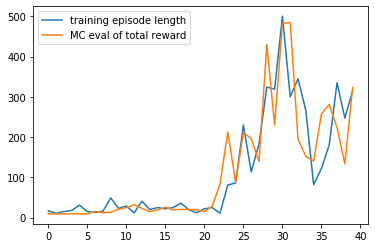

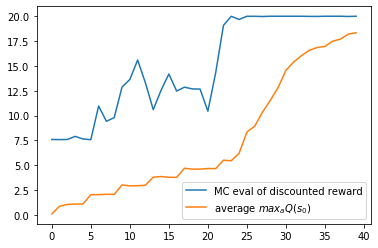

In [32]:
plt.plot(ep_length, label="training episode length")
plt.plot(tot_rewards, label="MC eval of total reward")
plt.legend()
plt.figure()
plt.plot(disc_rewards, label="MC eval of discounted reward")
plt.plot(Q0, label="average $max_a Q(s_0)$")
plt.legend();

Remarks on CartPole:
- Have you noted that Q overestimates the true value of the optimal policy? More on this in [this paper](https://papers.nips.cc/paper/3964-double-q-learning) if you are interested.
- Have you noted that the greedy policy is optimal much sooner than the $Q$ function?
- Have you remarked that the greedy policy performs well much sooner than the agent's policy (which is $\epsilon$-greedy)?
- Can you anticipate the importance of well tuned exploration, for instance if the state space is much larger, or if parts of it are very hard to reach?
- Can you anticipate the effect of taking a larger $\gamma$?

Remarks on SwingUp:
- Did your DQN learn to avoid the -10 penalty instead of swinging up? The exploration question becomes a crucial issue, doesn't it?

In [ ]:
# Now let's train on swingup

config = {'observation_space': swingup.observation_space.shape[0],
          'nb_actions': swingup.action_space.n,
          'learning_rate': 0.001,
          'gamma': 0.95,
          'buffer_size': 1000000,
          'epsilon_min': 0.01,
          'epsilon_max': 1.,
          'epsilon_stop': 10000,
          'epsilon_delay_decay': 100,
          'batch_size': 20,
          'gradient_steps': 10,
          'update_target_freq': 100,
          'nb_trials': 0}

DQN = torch.nn.Sequential(nn.Linear(swingup.observation_space.shape[0], 24),
                          nn.ReLU(),
                          nn.Linear(24, 24),
                          nn.ReLU(), 
                          nn.Linear(24, swingup.action_space.n)).to(device)

#DQN.load_state_dict(torch.load("cart_pole_dqn.pth"))

agent = DQN_agent(config, DQN)
ep_length, disc_rewards, tot_rewards, Q0 = agent.train(swingup, 30)
torch.save(DQN.state_dict(), "swingup_dqn.pth")

In [ ]:
DQN.load_state_dict(torch.load("swingup_dqn.pth"))
x = swingup.reset()
swingup.render()
tot_rew = 0
for i in range(1000):
    a = greedy_action(DQN, x)
    y, r, d, _ = swingup.step(a)
    swingup.render()
    x=y
    tot_rew += r
    if d:
        break

print(i)
print(tot_rew)

swingup.close()

# <a id="sec7"></a>DQN on image-based tasks

Now it's time to turn towards Pong. As you noted earlier, the frame information in Pong is not sufficient to define an MDP, but stacking several frames together allows to recover the Markov property.

we could wish to modify the previous replay buffer so that frames are stored only once (for memory efficiency). Then this new replay buffer would still need to return stacks of 4 frames when `sample()` is called.

Fortunately, there's a simpler way to do that.
We can use a wrapper (provided by Gym in this case) so that calling env.step(a) returns a stack of 4 frames.
This wrapper actually only stores each frame once which optimizes memory efficiency. This way, we can keep on using our previous replay buffer class.

In [ ]:
from gym.wrappers import FrameStack
pong = FrameStack(pong, 4)

In [ ]:
x = pong.reset()
print(torch.Tensor(x).shape)

The two DQN papers ([Playing Atari with Deep Reinforcement Learning](https://arxiv.org/abs/1312.5602) and [Human-level control through deep reinforcement learning](https://deepmind.com/research/publications/human-level-control-through-deep-reinforcement-learning)) actually introduce two different neural network architectures.

The 2013 paper uses this architecture:
- input: $84\times 84\times 4$ image (the last 4 frames)
- layer 1: Convolutions with 16 filters of size $8\times 8$ and stride 4. The activation is a ReLU function.
- layer 2: Convolutions with 32 filters of size $4\times 4$ and stride 2. The activation is a ReLU function.
- layer 3: Fully connected with 256 ReLU units
- layer 4 (output): Fully connected with 2 linear units (one for each action's value)

The 2015 paper 
- input: $84\times 84\times 4$ image (the last 4 frames)
- layer 1: Convolutions with 32 filters of size $8\times 8$ and stride 4. The activation is a ReLU function.
- layer 2: Convolutions with 64 filters of size $4\times 4$ and stride 2. The activation is a ReLU function.
- layer 3: Convolutions with 64 filters of size $3\times 3$ and stride 1. The activation is a ReLU function.
- layer 4: Fully connected with 512 ReLU units
- layer 5 (output): Fully connected with 2 linear units (one for each action's value)

Also, it is a good practice to pre-fill the replay buffer with randomly sampled experience. The 2015 paper runs a random policy for 50000 steps to feed the replay buffer before training.

<div class="alert alert-warning">
    
**Exercice:** Create the corresponding neural network and adapt your optimization code from the previous exercice to train on Pong (you can take $C$ much larger, in the order of $10000$).
</div>
Caveat: unless you have a GPU and a fair amount of time ahead of you, it is recommended to run this computation on a cloud computing service (or on a dediated machine).

In [ ]:
# YOUR DQN CODE FOR PONG

In [ ]:
class AtariCNN(nn.Module):
    def __init__(self, in_channels=4, n_actions=2):
        super(AtariCNN, self).__init__()
        self.conv1 = nn.Conv2d(in_channels, 32, kernel_size=8, stride=4)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=4, stride=2)
        self.conv3 = nn.Conv2d(64, 64, kernel_size=3, stride=1)
        self.fc4 = nn.Linear(7 * 7 * 64, 512)
        self.head = nn.Linear(512, n_actions)
      
    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = F.relu(self.conv2(x))
        x = F.relu(self.conv3(x))
        x = F.relu(self.fc4(x.view(x.size(0), -1)))
        return self.head(x)

In [ ]:
from tqdm import trange

config = {'observation_space': cartpole.observation_space.shape[0],
          'nb_actions': cartpole.action_space.n,
          'learning_rate': 0.001,
          'gamma': 0.95,
          'buffer_size': 1000000,
          'epsilon_min': 0.1,
          'epsilon_max': 1.,
          'epsilon_stop': 1000000,
          'epsilon_delay_decay': 0,
          'batch_size': 32,
          'gradient_steps': 10,
          'update_target_freq': 10000,
          'nb_trials': 0}

AtariDQN = AtariCNN()

agent = DQN_agent(config, AtariDQN)

# pre-fill the replay buffer
x = pong.reset()
for t in trange(50000):
    a = np.random.randint(2)
    y, r, d, _ = pong.step(a)
    agent.memory.append(x, a, r, y, d)
    if d:
        x = pong.reset()
    else:
        x = y

# train
ep_length, disc_rewards, tot_rewards, Q0 = agent.train(pong, 30)

To give you an idea of the behavior of a trained agent, you can check the following videos.

In [ ]:
from IPython.display import YouTubeVideo
YouTubeVideo("p88R2_3yWPA")

In [ ]:
YouTubeVideo("TmPfTpjtdgg")

# <a id="sec7"></a>Going further

A lot of contributions have built on the initial success of DQN. Among those, some are combined and discussed in the **[Rainbow: Combining Improvements in Deep Reinforcement Learning](https://arxiv.org/abs/1710.02298)** paper. We will simply summarize their key ideas here, by decreasing order of importance (according to the paper).

- N-step returns. Use samples that accumulate several returns rather than the 1-step return of TD(0).
- [Prioritized experience replay](https://arxiv.org/abs/1511.05952). Inspired by the model-based Prioritized Sweeping approach, bias the distribution used to sample mini-batches in order to present high residual samples to the optimizer. This accelerates the convergence in $L_\infty$ norm.
- [Distributional value functions](https://arxiv.org/abs/1707.06887). Instead of estimating $\mathbb{E}(\sum_t r_t)$, estimate the distribution of $\sum_t r_t$ and iterate on it.
- [NoisyNet](https://arxiv.org/abs/1706.10295). Instead of an $\epsilon$-greedy exploration strategy, introduce noise in the network's parameters to drive the exploration.
- [Dueling architecture](https://arxiv.org/abs/1511.06581). The neural network's architecture splits $Q$ into the estimation of a value $V(s)$ and an advantage $A(s,a)$ with shared first layers.
- [Double Q-learning](https://arxiv.org/abs/1509.06461). Q-learning is prone to over-estimation of the true optimal Q function (especially in high variance environments). Double Q-learning aims at compensating this weakness by introducing an under-estimation mechanism based on a second Q function.

Beyond these improvements, new work is published each year that lead to better understanding of the interplay between Deep Learning and RL.